<a href="https://colab.research.google.com/github/i-m-vivek/Scene-Classification/blob/master/ArcNet_FINAL_Documented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ArcNet

In [0]:
# import the lib. we wil need
from torch import nn
import torch
import torchvision
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar

--2020-02-28 19:08:15--  http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.30.100.255
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.30.100.255|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97270159 (93M) [application/x-tar]
Saving to: ‘resnet50_places365.pth.tar’

resnet50_places365. 100%[===================>]  92.76M  11.5MB/s    in 10s     

2020-02-28 19:08:31 (8.88 MB/s) - ‘resnet50_places365.pth.tar’ saved [97270159/97270159]



In [0]:
"""The num of channels the encoder will output 
this will be based on the encoder model 
we are using. For VGG16 it's 512"""
encode_out_num_channels= 2048

In [0]:
class Encoder(nn.Module):
    """
    VGG-16 Based model. 
    Takes a image and returns an encoded reprsentation of that image. 
    """

    def __init__(self, enc_img_size):
        """
        Initializes the Encoder Layer 
        Params: 
            enc_img_size: the size of the encoded image
                         after passing thourgh the VGG-16
        Returns: 
            output of shape (batch_size, encode_out_num_channels, enc_img_size*enc_img_size)
        """
        super(Encoder, self).__init__()
        self.enc_img_size = enc_img_size
        arch = 'resnet50'

        model_file = '%s_places365.pth.tar' % arch
        if not os.access(model_file, os.W_OK):
            weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
            os.system('wget ' + weight_url)

        model = models.__dict__[arch](num_classes=365)
        checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
        state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
        model.load_state_dict(state_dict)
        # load the pretrained model 
        # vgg16 = torchvision.models.vgg16_bn(pretrained=True)
        # remove the last pool and fc layer 
        modules = list(model.children())[:-2]
        
        # remake the network 
        self.resnet = nn.Sequential(*modules)
        self.pool = nn.AdaptiveAvgPool2d(enc_img_size)

        # for p in self.vgg16.parameters(enc_img_size):
        #     p.requires_grad = False

        # for c in list(self.vgg16.children())[4:]:
        #     for p in c.parameters():
        #         p.requires_grad = True

    def forward(self, images):
        """
        Does a forwad pass over the encoder model
        Params: 
            images = images from the dataset
        """
        out = self.resnet(images)
        out = self.pool(out)
        encoder_out = out.view(-1, encode_out_num_channels, self.enc_img_size*self.enc_img_size)
        # (batch_size, encode_out_num_channels, enc_img_size*enc_img_size)
        return encoder_out

In [0]:
class Attention(nn.Module):
    """
    Attention Mask over the encoded image produced by the CNN. 

    It takes the input of the LSTM Cell state to update its values & 
    encoded image.
    We will use a hidden Layer to transform the output of
    the LSTM to the dimension the encoded image.
    After that softmax will be applied on that vector. 
    After that element wise product of the image and the attention vector
    will be taken. This vector will be passed to the LSTM again. 
    """

    def __init__(self, encoder_dim, decoder_dim):
        """
        Initialize the Attention Layer. 
        Args:
            encoder_dim -> the height or width dimension of the output of the VGG16 (num_channels, H, W). 
            decoder_dim -> the dimension of the output of the decoder.
        """
        super(Attention, self).__init__()
        self.encoder_dim = encoder_dim

        # linear layer to transform decoder's output to attention dimension
        self.decoder_att = nn.Linear(decoder_dim, encoder_dim*encoder_dim)
        # softmax layer over the output of the above linear layer
        self.softmax = nn.Softmax(dim=1) 
        # avg. pool the output after applying the softmax over it
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, encoder_out, decoder_hidden):
        """
        Does a forward pass.
        Args: 
            encoder_out -> the output of the encoder (batch_size, encode_out_num_channels, encoder_dim*encoder_dim)
            decoder_hidden -> the output of the decoder (batch_size, decoder_dim)
        Returns: 
            attention_weighted_encoding (batch_size, encode_out_num_channels)
        """

        # (batch_size, encoder_dim*encoder_dim)
        decoder2att = self.decoder_att(decoder_hidden)
        # (batch_size, encoder_dim*encoder_dim)
        attn = self.softmax(decoder2att)

        # calculate the attention over the image
        # (batch_size, encode_out_num_channels,  encoder_dim*encoder_dim)
        attention_weighted_encoding = encoder_out*(attn.unsqueeze(1))
        # Reshape to (batch_size, encode_out_num_channels, encoder_dim, encoder_dim)
        attention_weighted_encoding = attention_weighted_encoding.view(-1, encode_out_num_channels, self.encoder_dim, self.encoder_dim)
        # apply Adaptive Avg. Pool 
        pooled = self.avg_pool(attention_weighted_encoding) # (batch_size, encode_out_num_channels, 1, 1)
        attention_weighted_encoding = pooled.view(-1, encode_out_num_channels) # (batch_size, encode_out_num_channels)
        return attention_weighted_encoding

In [0]:
class Decoder(nn.Module):
    """
    This will recieve the input from the Attention Layer & encoder,
    that will be passed on to the LSTM cell to do it's work.
    """

    def __init__(self, encoder_dim, decoder_dim1, decoder_dim2, decoder_dim3, num_classes, num_lstm_cell):
        """
        Args: 
        encoder_dim ->  the height or width dimension of the output of the VGG16 (num_channels, H, W).
        decoder_dim1 -> the dim. of the decoder1
        decoder_dim2 -> the dim. of the decoder2 
        decoder_dim3 -> the dim. of the decoder3 
        num_lstm_cell -> the recurrence number
        num_classes -> the number of classes
        """
        super(Decoder, self).__init__()

        self.encoder_dim = encoder_dim
        self.decoder_dim1 = decoder_dim1
        self.decoder_dim2 = decoder_dim2
        self.decoder_dim3 = decoder_dim3
        self.num_classes = num_classes
        self.num_lstm_cell = num_lstm_cell

        self.attention = Attention(encoder_dim, decoder_dim1)
        self.decode_step1 = nn.LSTMCell(encode_out_num_channels, decoder_dim1, bias=True)
        self.decode_step2 = nn.LSTMCell(decoder_dim1, decoder_dim2, bias=True)
        self.decode_step3 = nn.LSTMCell(decoder_dim2, decoder_dim3, bias=True)
        self.last_linear = nn.Linear(decoder_dim3, num_classes)
        self.softmax = nn.Softmax(dim = 1)

        self.init_h1 = nn.Linear(encoder_dim*encoder_dim, decoder_dim1)  # linear layer to find initial hidden state of LSTMCell-1
        self.init_c1 = nn.Linear(encoder_dim*encoder_dim, decoder_dim1) 
        self.init_h2 = nn.Linear(encoder_dim*encoder_dim, decoder_dim2)  # linear layer to find initial hidden state of LSTMCell-2
        self.init_c2 = nn.Linear(encoder_dim*encoder_dim, decoder_dim2) 
        self.init_h3 = nn.Linear(encoder_dim*encoder_dim, decoder_dim3)  # linear layer to find initial hidden state of LSTMCell-3
        self.init_c3 = nn.Linear(encoder_dim*encoder_dim, decoder_dim3) 
        

    def init_hidden_state(self, encoder_out):
        """
        Initializes the param of h, c for 3 stacked LSTM 
        Args: 
            encoder_out -> the output of the encoder (batch_size, encode_out_num_channels, encoder_dim*encoder_dim)
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h1 = self.init_h1(mean_encoder_out)  # (batch_size, decoder_dim)
        c1 = self.init_c1(mean_encoder_out)

        h2 = self.init_h2(mean_encoder_out)  # (batch_size, decoder_dim)
        c2 = self.init_c2(mean_encoder_out)

        h3 = self.init_h3(mean_encoder_out)  # (batch_size, decoder_dim)
        c3 = self.init_c3(mean_encoder_out)
        return h1, c1, h2, c2, h3, c3

    def forward(self, encoder_out):
        """
        Does a forward pass.
        Args:
            encoder_out -> the output of the encoder (batch_size, encode_out_num_channels, encoder_dim*encoder_dim)
        """
        
        batch_size = encoder_out.size(0)
        h1, c1, h2, c2, h3, c3  = self.init_hidden_state(encoder_out)

        # stores the output of the LSTM Cells (We are having num_lstm_cell number of cells)
        y_complete = torch.zeros(size = (self.num_lstm_cell, batch_size, self.num_classes))

        for i in range(self.num_lstm_cell):
            attention_weighted_encoding = self.attention(encoder_out, h1) # (batch_size, encode_out_num_channels)
            h1, c1 = self.decode_step1(attention_weighted_encoding, (h1, c1)) # (batch_size, decoder_dim1), # (batch_size, decoder_dim1)
            h2, c2 = self.decode_step2(h1, (h2, c2)) # (batch_size, decoder_dim2), # (batch_size, decoder_dim2)  
            h3, c3 = self.decode_step3(h2, (h3, c3)) # (batch_size, decoder_dim3), # (batch_size, decoder_dim3)
            out = self.last_linear(h3) # (batch_size, num_classes)
            y_t = self.softmax(out) # (batch_size, num_classes)
            y_complete[i] = y_t

        return y_complete.sum(dim =0 )

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip "/content/drive/My Drive/Competition Data/competition_data.zip"

Archive:  /content/drive/My Drive/Competition Data/competition_data.zip
   creating: data/
   creating: data/train/
   creating: data/train/airport/
  inflating: data/train/airport/airport(1).jpg  
  inflating: data/train/airport/airport(10).jpg  
  inflating: data/train/airport/airport(11).jpg  
  inflating: data/train/airport/airport(13).jpg  
  inflating: data/train/airport/airport(14).jpg  
  inflating: data/train/airport/airport(15).jpg  
  inflating: data/train/airport/airport(17).jpg  
  inflating: data/train/airport/airport(18).jpg  
  inflating: data/train/airport/airport(19).jpg  
  inflating: data/train/airport/airport(2).jpg  
  inflating: data/train/airport/airport(20).jpg  
  inflating: data/train/airport/airport(21).jpg  
  inflating: data/train/airport/airport(22).jpg  
  inflating: data/train/airport/airport(23).jpg  
  inflating: data/train/airport/airport(25).jpg  
  inflating: data/train/airport/airport(26).jpg  
  inflating: data/train/airport/airport(27).jpg  
  i

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(.2),
        transforms.RandomVerticalFlip(.3),
        transforms.RandomRotation(5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
data_dir = "/content/data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True) for x in ["train", "val"]}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

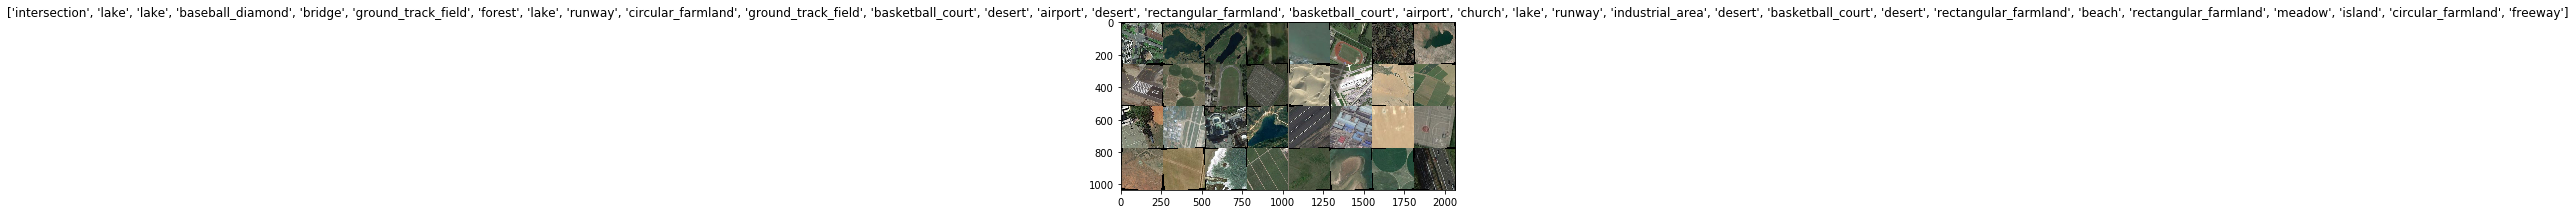

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
from tqdm import tqdm_notebook as tqdm
def train_model(encoder, model, criterion, optimizer, num_epochs=50):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # loss = {"train": [], "val": []}
    # acc = {"train": [], "val": []}
    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                encoder.train()  # Set model to training mode
                model.train()
            else:
                encoder.eval()   # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], total=len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    inputs = encoder(inputs)
                    outputs = model(inputs).to(device)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
                # scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_encoder_wts = copy.deepcopy(encoder.state_dict())

            if phase == "val":
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

            if phase == "train":
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    encoder.load_state_dict(best_encoder_wts)
    return model, encoder, {"loss": [train_loss_history, val_loss_history], 
                            "accuracy": [train_acc_history, val_acc_history]}

In [0]:
encoder = Encoder(8).to(device)
model_ft = Decoder(8, 32, 64, 128, 31, 30)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss().to(device)

plist = [
        {'params': encoder.parameters(), 'lr': 1e-5, "weight_decay": 1e-4},
        {'params': model_ft.parameters(), 'lr': 5e-3, "weight_decay": 1e-4}
        ]

optimizer_ft = optim.Adam(plist)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
# encoder

In [0]:
model_ft, encoder_ft, models_history = train_model(encoder, model_ft, criterion, optimizer_ft,
                       num_epochs=50)

Epoch 0/49
----------



train Loss: 3.3650 Acc: 0.0258



val Loss: 3.3134 Acc: 0.0408

Epoch 1/49
----------



train Loss: 3.3016 Acc: 0.0425



val Loss: 3.2009 Acc: 0.1071

Epoch 2/49
----------



train Loss: 3.0934 Acc: 0.0983



val Loss: 2.8712 Acc: 0.1582

Epoch 3/49
----------



train Loss: 2.7468 Acc: 0.1450



val Loss: 2.5879 Acc: 0.2245

Epoch 4/49
----------



train Loss: 2.5307 Acc: 0.2058



val Loss: 2.3590 Acc: 0.2602

Epoch 5/49
----------



train Loss: 2.3336 Acc: 0.2342



val Loss: 2.1483 Acc: 0.3316

Epoch 6/49
----------



train Loss: 2.1829 Acc: 0.2742



val Loss: 1.8809 Acc: 0.3571

Epoch 7/49
----------



train Loss: 2.0448 Acc: 0.3067



val Loss: 1.8678 Acc: 0.3929

Epoch 8/49
----------



train Loss: 1.9792 Acc: 0.3550



val Loss: 1.6776 Acc: 0.4490

Epoch 9/49
----------



train Loss: 1.7975 Acc: 0.4092



val Loss: 1.5808 Acc: 0.5153

Epoch 10/49
----------



train Loss: 1.5858 Acc: 0.4725



val Loss: 1.5853 Acc: 0.4847

Epoch 11/49
----------



train Loss: 1.5553 Acc: 0.4967



val Loss: 1.3843 Acc: 0.5306

Epoch 12/49
----------



train Loss: 1.4434 Acc: 0.5258



val Loss: 1.2278 Acc: 0.5714

Epoch 13/49
----------



train Loss: 1.2702 Acc: 0.5808



val Loss: 1.2673 Acc: 0.5408

Epoch 14/49
----------



train Loss: 1.1969 Acc: 0.5875



val Loss: 1.1239 Acc: 0.6582

Epoch 15/49
----------



train Loss: 1.2332 Acc: 0.5950



val Loss: 1.0516 Acc: 0.6633

Epoch 16/49
----------



train Loss: 1.1465 Acc: 0.6217



val Loss: 1.0348 Acc: 0.6837

Epoch 17/49
----------



train Loss: 1.1550 Acc: 0.6217



val Loss: 0.9601 Acc: 0.7347

Epoch 18/49
----------



train Loss: 1.1215 Acc: 0.6533



val Loss: 0.9908 Acc: 0.6990

Epoch 19/49
----------



train Loss: 1.0778 Acc: 0.6650



val Loss: 1.0065 Acc: 0.6684

Epoch 20/49
----------



train Loss: 1.0465 Acc: 0.6717



val Loss: 0.9556 Acc: 0.7245

Epoch 21/49
----------



train Loss: 0.9516 Acc: 0.7100



val Loss: 1.0767 Acc: 0.6684

Epoch 22/49
----------



train Loss: 0.9901 Acc: 0.6925



val Loss: 0.8950 Acc: 0.7143

Epoch 23/49
----------



train Loss: 0.8454 Acc: 0.7358



val Loss: 0.8301 Acc: 0.7602

Epoch 24/49
----------



train Loss: 0.8737 Acc: 0.7200



val Loss: 0.8450 Acc: 0.7398

Epoch 25/49
----------



train Loss: 0.8164 Acc: 0.7500



val Loss: 0.7528 Acc: 0.7908

Epoch 26/49
----------



train Loss: 0.7735 Acc: 0.7617



val Loss: 0.8013 Acc: 0.7602

Epoch 27/49
----------



train Loss: 0.8403 Acc: 0.7433



val Loss: 0.7826 Acc: 0.7500

Epoch 28/49
----------



train Loss: 0.8329 Acc: 0.7358



val Loss: 0.7377 Acc: 0.7602

Epoch 29/49
----------



train Loss: 0.7687 Acc: 0.7633



val Loss: 0.7372 Acc: 0.7551

Epoch 30/49
----------



train Loss: 0.6981 Acc: 0.7775



val Loss: 0.6496 Acc: 0.8163

Epoch 31/49
----------



train Loss: 0.7053 Acc: 0.7750



val Loss: 0.8462 Acc: 0.7398

Epoch 32/49
----------



train Loss: 0.6938 Acc: 0.7817



val Loss: 0.7118 Acc: 0.7806

Epoch 33/49
----------



train Loss: 0.6408 Acc: 0.8042



val Loss: 0.6447 Acc: 0.8265

Epoch 34/49
----------



train Loss: 0.6148 Acc: 0.8175



val Loss: 0.7359 Acc: 0.8010

Epoch 35/49
----------



train Loss: 0.5995 Acc: 0.8242



val Loss: 0.6640 Acc: 0.8265

Epoch 36/49
----------



train Loss: 0.6317 Acc: 0.8050



val Loss: 0.7125 Acc: 0.8112

Epoch 37/49
----------



train Loss: 0.5283 Acc: 0.8392



val Loss: 0.6088 Acc: 0.8367

Epoch 38/49
----------



train Loss: 0.6415 Acc: 0.8067



val Loss: 0.6718 Acc: 0.8265

Epoch 39/49
----------



train Loss: 0.6640 Acc: 0.8025



val Loss: 0.6219 Acc: 0.8316

Epoch 40/49
----------



train Loss: 0.6113 Acc: 0.8200



val Loss: 0.6720 Acc: 0.8112

Epoch 41/49
----------



train Loss: 0.5798 Acc: 0.8158



val Loss: 0.6866 Acc: 0.8163

Epoch 42/49
----------



train Loss: 0.5764 Acc: 0.8292



val Loss: 0.6846 Acc: 0.8010

Epoch 43/49
----------



train Loss: 0.4701 Acc: 0.8458



val Loss: 0.6510 Acc: 0.8316

Epoch 44/49
----------



train Loss: 0.5261 Acc: 0.8500



val Loss: 0.5810 Acc: 0.8520

Epoch 45/49
----------



train Loss: 0.5362 Acc: 0.8350



val Loss: 0.6941 Acc: 0.8061

Epoch 46/49
----------



train Loss: 0.5091 Acc: 0.8442



val Loss: 0.7397 Acc: 0.7959

Epoch 47/49
----------



train Loss: 0.5388 Acc: 0.8417



val Loss: 0.5808 Acc: 0.8367

Epoch 48/49
----------



train Loss: 0.5660 Acc: 0.8408



val Loss: 0.6394 Acc: 0.8316

Epoch 49/49
----------



train Loss: 0.5422 Acc: 0.8333



val Loss: 0.6717 Acc: 0.8163

Training complete in 22m 40s
Best val Acc: 0.852041


In [0]:
torch.save(model_ft.state_dict(), "/content/drive/My Drive/model_arcNet_150Epochs_3LSTM_30Recurrence_Places.pth")
torch.save(encoder_ft.state_dict(), "/content/drive/My Drive/encoder_arcNet_150Epochs_3LSTM_30Recurrence_Places.pth")

In [0]:
train_acc= models_history["accuracy"][0]
val_acc= models_history["accuracy"][1]

train_loss= models_history["loss"][0]
val_loss= models_history["loss"][1]

In [0]:
train_acc = [h.cpu().numpy() for h in train_acc]
val_acc = [h.cpu().numpy() for h in val_acc]

In [0]:
import seaborn as sns 
sns.set_style("white")

Text(0.5, 1.0, 'Accuracy Plots')

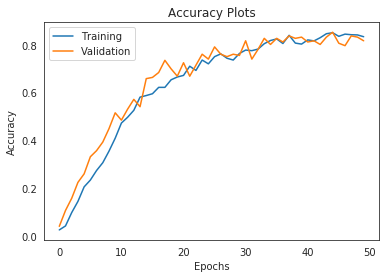

In [0]:
plt.plot(train_acc, label= "Training")
plt.plot(val_acc, label= "Validation")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Plots")

Text(0.5, 1.0, 'Loss Plots')

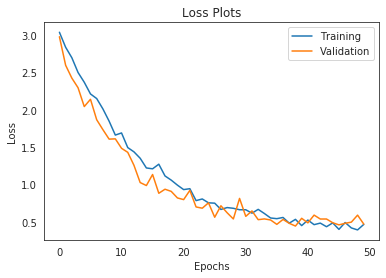

In [0]:
plt.plot(train_loss, label= "Training")
plt.plot(val_loss, label= "Validation")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Plots")

In [0]:
# models_history pickle
import pickle 

with open('/content/drive/My Drive/models_history-100EPOCHS.pickle', 'wb') as handle:
    pickle.dump(models_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Evaluating the model

In [0]:
encoder_model = Encoder(8)
decoder_model = Decoder(8, 32, 64, 128, 31, 20)

encoder_model.load_state_dict(torch.load("/content/drive/My Drive/encoder_arcNet_150Epochs_3LSTM_30Recurrence_Places.pth"))
decoder_model.load_state_dict(torch.load("/content/drive/My Drive/model_arcNet_150Epochs_3LSTM_30Recurrence_Places.pth"))

<All keys matched successfully>

In [0]:
val_dataloader = torch.utils.data.DataLoader(image_datasets["val"], batch_size= 4, shuffle= True, drop_last=True)

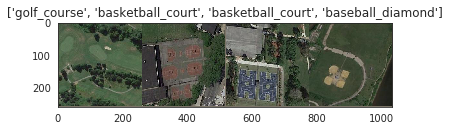

In [0]:
dataiter = iter(val_dataloader)
images, labels = dataiter.next()

out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

In [0]:
out_encoder_model = encoder_model(images)
out_decoder_model = decoder_model(out_encoder_model)

In [0]:
_, predicted = torch.max(out_decoder_model, 1)

In [0]:
[class_names[x] for x in predicted]

['lake', 'basketball_court', 'harbor', 'circular_farmland']

In [0]:
model_ft_cpu = model_ft.to(torch.device('cpu'))
encoder_ft_cpu = encoder_ft.to(torch.device('cpu'))

In [0]:
corrects = 0
total = 0
class_correct = list(0. for i in range(31))
class_total = list(0. for i in range(31))
preds = []
true_labels = []
images_list = []
with torch.no_grad():
    for data in val_dataloader:
        images, labels = data 
        out_encoder_model = encoder_model(images)
        out_decoder_model = decoder_model(out_encoder_model)
        _, predicted = torch.max(out_decoder_model, 1)
        total += labels.size(0)
        corrects += (predicted == labels).sum().item()
        c = (predicted == labels).squeeze()
        for i in range(4):
            preds.append(predicted[i])
            images_list.append(images[i])
            label = labels[i]
            true_labels.append(label)
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [0]:
print("Accuracy on Val Data: ", round((corrects/total)*100, 3),"%")

Accuracy on Val Data:  86.522 %


In [0]:
for i in range(31):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 87 %
Accuracy of airport : 85 %
Accuracy of baseball_diamond : 100 %
Accuracy of basketball_court : 100 %
Accuracy of beach : 100 %
Accuracy of bridge : 88 %
Accuracy of chaparral : 93 %
Accuracy of church : 66 %
Accuracy of circular_farmland : 73 %
Accuracy of commercial_area : 64 %
Accuracy of dense_residential : 75 %
Accuracy of desert : 83 %
Accuracy of forest : 100 %
Accuracy of freeway : 76 %
Accuracy of golf_course : 88 %
Accuracy of ground_track_field : 100 %
Accuracy of harbor : 93 %
Accuracy of industrial_area : 73 %
Accuracy of intersection : 82 %
Accuracy of island : 92 %
Accuracy of  lake : 90 %
Accuracy of meadow : 86 %
Accuracy of medium_residential : 75 %
Accuracy of mobile_home_park : 80 %
Accuracy of mountain : 93 %
Accuracy of overpass : 64 %
Accuracy of parking_lot : 94 %
Accuracy of railway : 100 %
Accuracy of rectangular_farmland : 84 %
Accuracy of roundabout : 93 %
Accuracy of runway : 93 %


In [0]:
preds = [int(pred.numpy()) for pred in preds]
true_labels = [int(true_label.numpy()) for true_label in true_labels]

true_labels = [class_names[x] for x in true_labels]
preds = [class_names[x] for x in preds]

In [0]:
! pip install -q scikit-plot

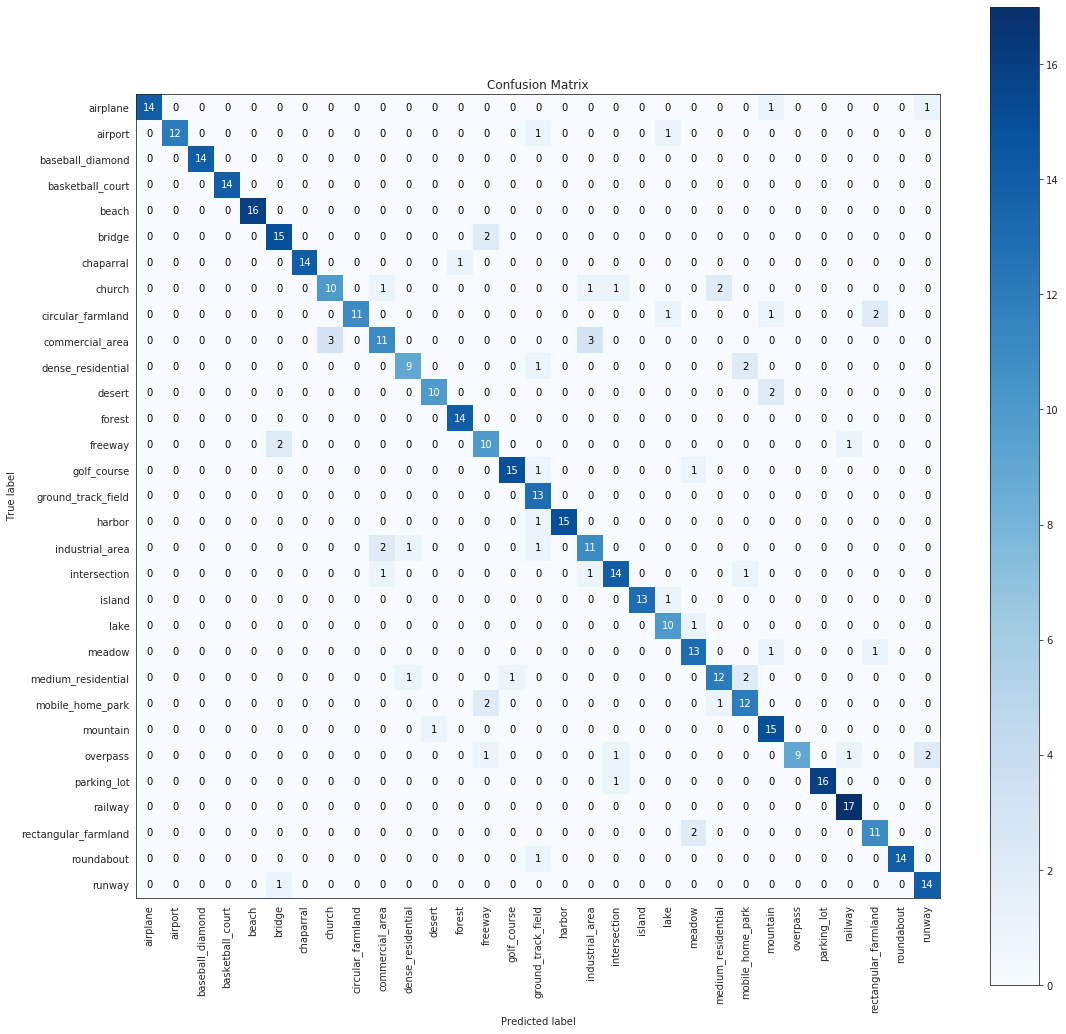

In [0]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    true_labels, 
    preds,
    x_tick_rotation= 90,
    figsize=(18,18))

In [0]:
images_list = [torch.Tensor(images) for images in images_list]

In [0]:
# Examples Of Incorrectly Classified
overpass_freeway = []
for i in range(len(preds)):
    if true_labels[i] == "overpass" and preds[i] == "freeway":
            overpass_freeway.append(images_list[i])

In [0]:
overpass_freeway_grid = torchvision.utils.make_grid(overpass_freeway)

In [0]:
overpass = []
freeway = []
for i in range(len(true_labels)):
    if true_labels[i] == "overpass":
        overpass.append(images_list[i])
    elif true_labels[i] == "freeway":
        freeway.append(images_list[i])

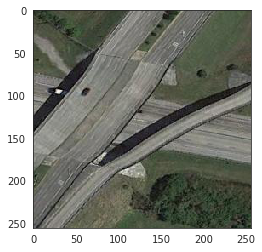

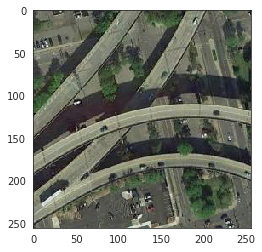

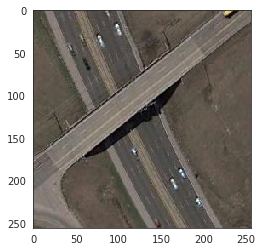

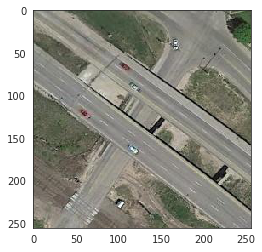

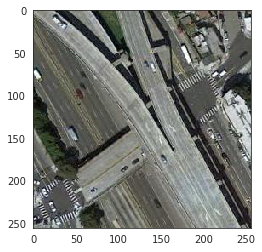

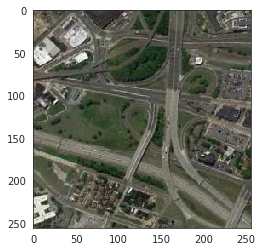

In [0]:
# Overpass
for i in range(len(overpass[:6])):
    imshow(overpass[i])
    plt.show()

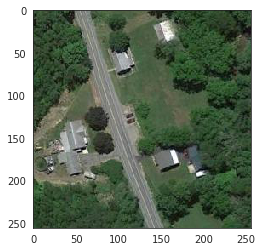

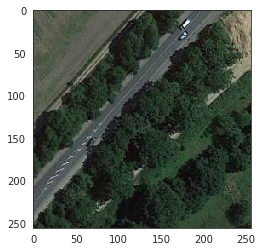

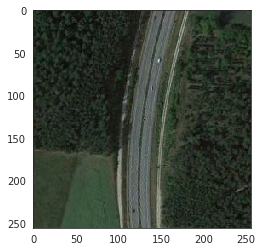

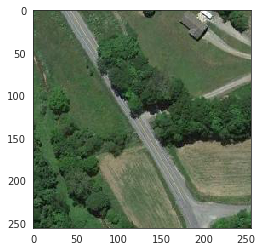

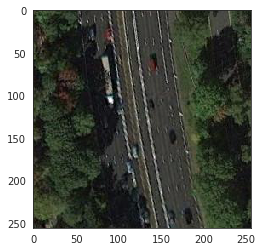

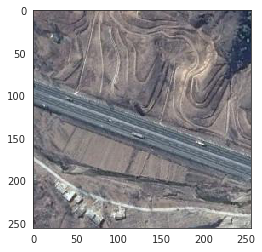

In [0]:
# Freeway 
for i in range(len(freeway[:6])):
    imshow(freeway[i])
    plt.show()

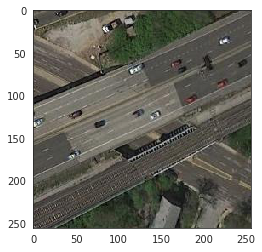

In [0]:
# Overpass but classified as freeway
for i in range(len(overpass_freeway)):
    imshow(overpass_freeway[i])
    plt.show()

## Future Work

## CutMix & MixUp Snippets

In [0]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets, shuffled_targets, lam]
    return data, targets

def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets, shuffled_targets, lam]

    return data, targets


def cutmix_criterion(preds, targets):
    targets1, targets2, lam = targets[0], targets[1], targets[2], targets[3]
    criterion = nn.CrossEntropyLoss(reduction='mean').to(device)
    return lam * criterion(preds, targets1) + (1 - lam) * criterion(preds, targets2) 

def mixup_criterion(preds, targets):
    targets1, targets2, lam = targets[0], targets[1], targets[2]
    criterion = nn.CrossEntropyLoss(reduction='mean').to(device)
    return lam * criterion(preds, targets1) + (1 - lam) * criterion(preds, targets2)

In [0]:
for i, (image_id, images, label1, label2, label3) in enumerate(data_loader_train):
            images = images.to(device)
            label1 = label1.to(device)
            label2 = label2.to(device)
            label3 = label3.to(device)
            # print (image_id, label1, label2, label3)

            if np.random.rand()<0.5:
                images, targets = mixup(images, label1, label2, label3, 0.4)
                output1, output2, output3 = model(images)
                loss = mixup_criterion(output1,output2,output3, targets) 
            else:
                images, targets = cutmix(images, label1, label2, label3, 0.4)
                output1, output2, output3 = model(images)
                loss = cutmix_criterion(output1,output2,output3, targets) 

## Data Splitting Snippet

In [0]:
import os 
os.listdir("/content/Images")

['freeway',
 'mobile_home_park',
 'baseball_diamond',
 'chaparral',
 'meadow',
 'forest',
 'ground_track_field',
 'harbor',
 'lake',
 'railway',
 'parking_lot',
 'rectangular_farmland',
 'overpass',
 'basketball_court',
 'desert',
 'mountain',
 'bridge',
 'medium_residential',
 'dense_residential',
 'church',
 'industrial_area',
 'island',
 'commercial_area',
 'beach',
 'golf_course',
 'airplane',
 'airport',
 'intersection',
 'runway',
 'roundabout',
 'circular_farmland']

In [0]:
data_dir = "/content/data/"
import shutil
for i in os.listdir("/content/Images"):
    random_num = np.random.permutation(60)
    os.mkdir(data_dir + "train/" + i)
    os.mkdir(data_dir + "val/" + i)
    
    images = np.array(os.listdir("/content/Images/" + i))
    val_images = images[random_num[:18]]
    train_images = images[random_num[18:]]

    for v in val_images:
        shutil.copy("/content/Images/" + i + "/"+ v, data_dir + "/val/" + i)
    for t in train_images:
        shutil.copy("/content/Images/" + i + "/"+ t, data_dir + "/train/" + i)    

In [0]:
# importing required modules 
from zipfile import ZipFile 
import os 
  
def get_all_file_paths(directory): 
  
    # initializing empty file paths list 
    file_paths = [] 
  
    # crawling through directory and subdirectories 
    for root, directories, files in os.walk(directory): 
        for filename in files: 
            # join the two strings in order to form the full filepath. 
            filepath = os.path.join(root, filename) 
            file_paths.append(filepath) 
  
    # returning all file paths 
    return file_paths         
  
def main(): 
    # path to folder which needs to be zipped 
    directory = '/content/data'
  
    # calling function to get all file paths in the directory 
    file_paths = get_all_file_paths(directory) 
  
    # printing the list of all files to be zipped 
    # print('Following files will be zipped:') 
    # for file_name in file_paths: 
    #     print(file_name) 
  
    # writing files to a zipfile 
    with ZipFile('optimal31.zip','w') as zip: 
        # writing each file one by one 
        for file in file_paths: 
            zip.write(file) 
  
    print('All files zipped successfully!')    

In [0]:
shutil.copy("/content/optimal31.zip","/content/drive/My Drive" )

'/content/drive/My Drive/optimal31.zip'

In [0]:
from PIL import Image
img = Image.open("/content/Images/baseball_diamond/baseball_diamond(1).jpg")

In [0]:
img_np = np.array(img)
img_tensor =torch.from_numpy(img_np)
img_tensor= img_tensor.unsqueeze(0)
img_tensor = img_tensor.float()
img_tensor = img_tensor.permute(0, 3, 1, 2)
img_tensor.shape

torch.Size([1, 3, 256, 256])

In [0]:
out_sample= model(img_tensor)

In [0]:
out_sample

tensor([[0.1795, 0.1912, 0.1451, 0.1650, 0.1623, 0.1784, 0.1621, 0.1513, 0.1645,
         0.1597, 0.1686, 0.1521, 0.1584, 0.1623, 0.1520, 0.1544, 0.1506, 0.1556,
         0.1672, 0.1693, 0.1550, 0.1566, 0.1683, 0.1651, 0.1626, 0.1439, 0.1625,
         0.1505, 0.1693, 0.1489, 0.1676]], grad_fn=<SumBackward1>)

In [0]:
out_sample_numpy = out_sample.detach().numpy()

In [0]:
s = 0
for i in range(5):
    s = s + out_sample_numpy[i][0]

In [0]:
s

array([0.15818974, 0.16531599, 0.16595496, 0.15781882, 0.15996298,
       0.15873607, 0.16053793, 0.1452478 , 0.1751461 , 0.17196783,
       0.1535007 , 0.17561392, 0.17392404, 0.14776008, 0.18574475,
       0.15684012, 0.14703108, 0.15857783, 0.16412285, 0.16812477,
       0.16157246, 0.1773306 , 0.17341146, 0.16027397, 0.17284726,
       0.15114982, 0.15856117, 0.14574121, 0.15490665, 0.15811794,
       0.13596919], dtype=float32)

In [0]:
out_sample.sum(dim=0)

tensor([[0.1582, 0.1653, 0.1660, 0.1578, 0.1600, 0.1587, 0.1605, 0.1452, 0.1751,
         0.1720, 0.1535, 0.1756, 0.1739, 0.1478, 0.1857, 0.1568, 0.1470, 0.1586,
         0.1641, 0.1681, 0.1616, 0.1773, 0.1734, 0.1603, 0.1728, 0.1511, 0.1586,
         0.1457, 0.1549, 0.1581, 0.1360]], grad_fn=<SumBackward1>)

In [0]:
out_np = np.array(out_sample)

In [0]:
out_np[0]

tensor([[0.0364, 0.0327, 0.0312, 0.0293, 0.0322, 0.0333, 0.0330, 0.0304, 0.0387,
         0.0351, 0.0313, 0.0322, 0.0297, 0.0347, 0.0348, 0.0357, 0.0292, 0.0287,
         0.0285, 0.0335, 0.0341, 0.0349, 0.0303, 0.0348, 0.0323, 0.0278, 0.0343,
         0.0272, 0.0349, 0.0298, 0.0291]], grad_fn=<SoftmaxBackward>)

In [0]:
img_tensor[0][1][2][3]

tensor(106.)